## Importing libraries

In [1]:
import pandas as pd
import numpy as np

from pandas import NA

import folium
from folium import plugins

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

## Loading the dataset

In [2]:
house = pd.read_csv("[dec 1] dot_house.csv")
condo = pd.read_csv("[dec 1] dot_condo.csv")
comm = pd.read_csv("[dec 1] dot_comm.csv")
apt = pd.read_csv("[dec 1] dot_apt.csv")

In [3]:
print(house.shape)
print(condo.shape)
print(comm.shape)
print(apt.shape)

(1250, 52)
(1250, 51)
(1250, 40)
(248, 51)


## Data cleaning

 - Check for NA values.
     - For bedrooms and specific facilities, replace NA values with $0$.
 - Drop irrelevant columns.
 - Drop duplicates based on all columns.
 - Outliers were removed with respect to each feature and property type.
 - Normalization

In [4]:
# List of source DataFrames
dataframes = [house, condo, comm, apt]
df_names = ["house", "condominium", "commercial", "apartment"]

# Collect NA counts in each DataFrame
na_counts_data = []
for df, name in zip(dataframes, df_names):
    # Replace "na" text with NaN if needed
    df.replace("na", pd.NA, inplace=True)
    
    # Count NA values in each column
    na_counts = df.isna().sum()
    
    # Append results with the source DataFrame name
    for column, count in na_counts.items():
        na_counts_data.append([name, column, count])

# Create the summary DataFrame
na_counts_df = pd.DataFrame(na_counts_data, columns=["Listing Type", "Feature", "NA Count"])

na_counts_df

,Listing Type,Feature,NA Count
0,house,title,1250
1,house,location,0
2,house,price,0
3,house,price_per_sqm,192
4,house,url,0
...,...,...,...
189,apartment,Grill,238
190,apartment,Guardhouse,233
191,apartment,Hot Tub,239
192,apartment,Natural gas,240


In [5]:
house['bedrooms'] = house['bedrooms'].fillna(0)
house['Fireplace'] = house['Fireplace'].fillna(0)
house['Cellar'] = house['Cellar'].fillna(0)

house = house.drop_duplicates().drop(columns = ["title", "address"])
house = house.replace({pd.NA: NA, np.nan: NA, 'NaN': NA})

In [6]:
condo['bedrooms'] = condo['bedrooms'].fillna(0)
condo['Patio'] = condo['Patio'].fillna(0)
condo['Cistern'] = condo['Cistern'].fillna(0)

condo['Panoramic view'] = condo['Panoramic view'].fillna(0)
condo['Library'] = condo['Library'].fillna(0)
condo['Terrace'] = condo['Terrace'].fillna(0)
condo['Heating'] = condo['Heating'].fillna(0)
condo['Fireplace'] = condo['Fireplace'].fillna(0)
condo['Built-in wardrobe'] = condo['Built-in wardrobe'].fillna(0)
condo['Cellar'] = condo['Cellar'].fillna(0)
condo['Grill'] = condo['Grill'].fillna(0)
condo['Hot Tub'] = condo['Hot Tub'].fillna(0)
condo['Natural gas'] = condo['Natural gas'].fillna(0)
condo['Office'] = condo['Office'].fillna(0)
condo['Sauna'] = condo['Sauna'].fillna(0)


condo = condo.drop_duplicates().drop(columns = ["title", "address"])
condo = condo.replace({pd.NA: NA, np.nan: NA, 'NaN': NA})


In [7]:
comm['bedrooms'] = comm['bedrooms'].fillna(0)
comm['Panoramic view'] = comm['Panoramic view'].fillna(0)
comm['Video cable'] = comm['Video cable'].fillna(0)
comm['Library'] = comm['Library'].fillna(0)
comm['Grill'] = comm['Grill'].fillna(0)
comm['Cistern'] = comm['Cistern'].fillna(0)
comm["Children's area"] = comm["Children's area"].fillna(0)
comm['Tennis court'] = comm['Tennis court'].fillna(0)

comm = comm.drop_duplicates().drop(columns = ["title", "address"])
comm = comm.replace({pd.NA: NA, np.nan: NA, 'NaN': NA})

In [8]:
apt['bedrooms'] = apt['bedrooms'].fillna(0)

apt['Swimming pool'] = apt['Swimming pool'].fillna(0)
apt['Gym'] = apt['Gym'].fillna(0)
apt['Garden'] = apt['Garden'].fillna(0)
apt["Children's area"] = apt["Children's area"].fillna(0)
apt['Concierge'] = apt['Concierge'].fillna(0)
apt['Library'] = apt['Library'].fillna(0)
apt['Tennis court'] = apt['Tennis court'].fillna(0)
apt['Sauna'] = apt['Sauna'].fillna(0)
apt['Roof garden'] = apt['Roof garden'].fillna(0)
apt['Patio'] = apt['Patio'].fillna(0)
apt['Heating'] = apt['Heating'].fillna(0)
apt['Fireplace'] = apt['Fireplace'].fillna(0)
apt['Grill'] = apt['Grill'].fillna(0)
apt['Guardhouse'] = apt['Guardhouse'].fillna(0)
apt['Hot Tub'] = apt['Hot Tub'].fillna(0)
apt['Natural gas'] = apt['Natural gas'].fillna(0)
apt['Office'] = apt['Office'].fillna(0)

apt = apt.drop_duplicates().drop(columns = ["title", "address"])
apt = apt.replace({pd.NA: NA, np.nan: NA, 'NaN': NA})

In [9]:
print(house.shape)
print(condo.shape)
print(comm.shape)
print(apt.shape)

(1230, 50)
(1226, 49)
(1246, 38)
(248, 49)


In [10]:
def create_property_map(data, center_lat=None, center_lon=None, zoom_start=12):
    """
    Create an interactive map of property listings using OpenStreetMap.
    
    Parameters:
    data: pandas DataFrame with required property information
    center_lat: float, latitude for map center (defaults to data mean)
    center_lon: float, longitude for map center (defaults to data mean)
    zoom_start: int, initial zoom level
    
    Returns:
    folium.Map object
    """
    # Calculate center if not provided
    if center_lat is None:
        center_lat = data['latitude'].mean()
    if center_lon is None:
        center_lon = data['longitude'].mean()
    
    # Create base map
    m = folium.Map(location=[center_lat, center_lon], 
                  zoom_start=zoom_start,
                  tiles='OpenStreetMap')
    
    # Add marker cluster
    marker_cluster = plugins.MarkerCluster()
    
    # Add markers for each property
    for idx, row in data.iterrows():
        # Format price - handle both string and numeric types
        try:
            price = float(str(row['price']).replace('$', '').replace(',', ''))
            price_display = f"${price:,.2f}"
        except (ValueError, TypeError):
            price_display = str(row['price'])
        
        # Create formatted popup content with HTML styling
        popup_content = f"""
        <div style="font-family: Arial, sans-serif; min-width: 200px;">
            <h4 style="margin-bottom: 10px;">Property {idx}</h4>
            <p style="margin: 5px 0;"><strong>Price:</strong> {price_display}</p>
            <hr style="margin: 10px 0;">
            <p style="margin: 5px 0;"><strong>Bedrooms:</strong> {row['bedrooms']}</p>
            <p style="margin: 5px 0;"><strong>Bathrooms:</strong> {row['bathrooms']}</p>
            <p style="margin: 5px 0;"><strong>Floor Area:</strong> {row['floor_area']} sq ft</p>
            <p style="margin: 5px 0;"><strong>Floor:</strong> {row['floor']}</p>
            <hr style="margin: 10px 0;">
            <p style="margin: 5px 0;"><strong>Location:</strong></p>
            <p style="margin: 5px 0;">Longitude: {row['longitude']}</p>
            <p style="margin: 5px 0;">Latitude: {row['latitude']}</p>
            <p style="margin: 5px 0;"><strong>Facilities:</strong> {row['facilities']}</p>
        </div>
        """
        
        # Create popup with formatted content
        popup = folium.Popup(popup_content, max_width=300)
        
        # Add marker with popup
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=popup,
            icon=folium.Icon(color='red', icon='info-sign')
        ).add_to(marker_cluster)
    
    marker_cluster.add_to(m)
    
    # Add fullscreen option
    plugins.Fullscreen().add_to(m)
    
    return m

In [11]:
house_map = create_property_map(house)
condo_map = create_property_map(condo)
comm_map = create_property_map(comm)
apt_map = create_property_map(apt)

house_map.save('house_map.html')
condo_map.save('condo_map.html')
comm_map.save('comm_map.html')
apt_map.save('apt_map.html')


Initial data processing summary:
Original number of properties: 1230
Properties after cleaning: 1223
Rows removed: 7


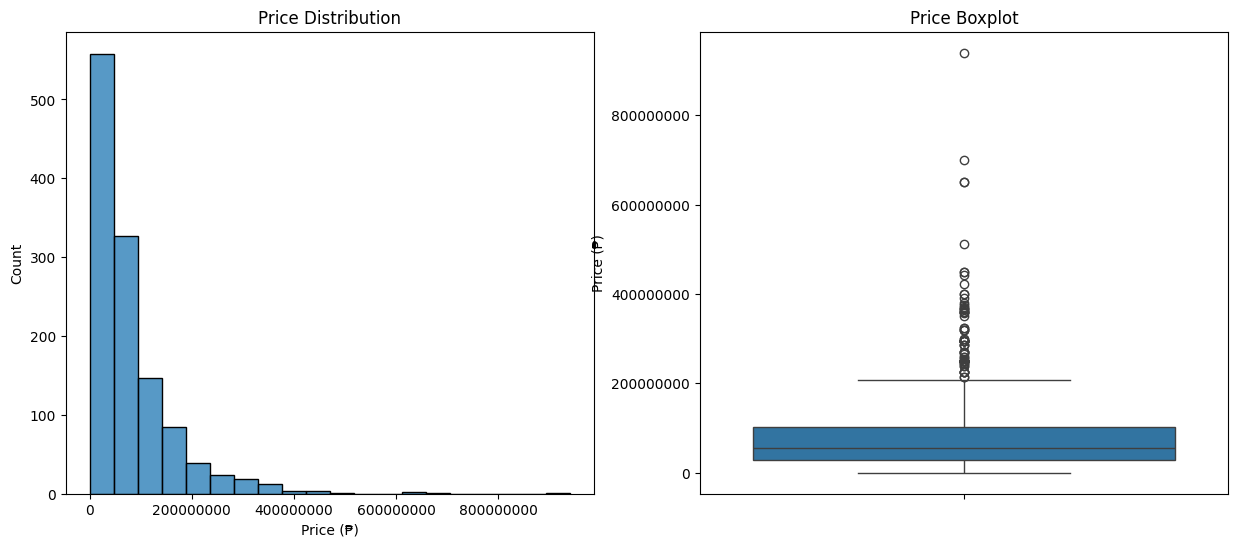

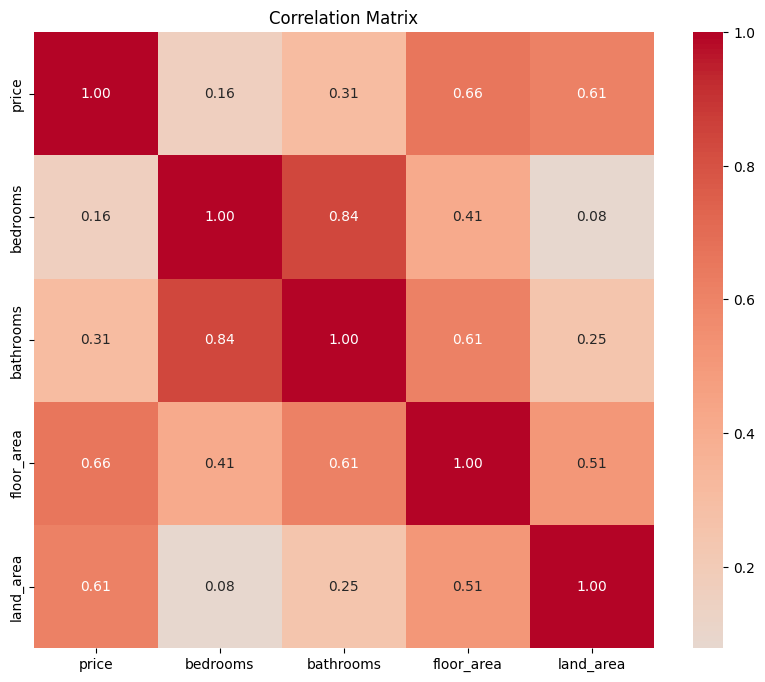

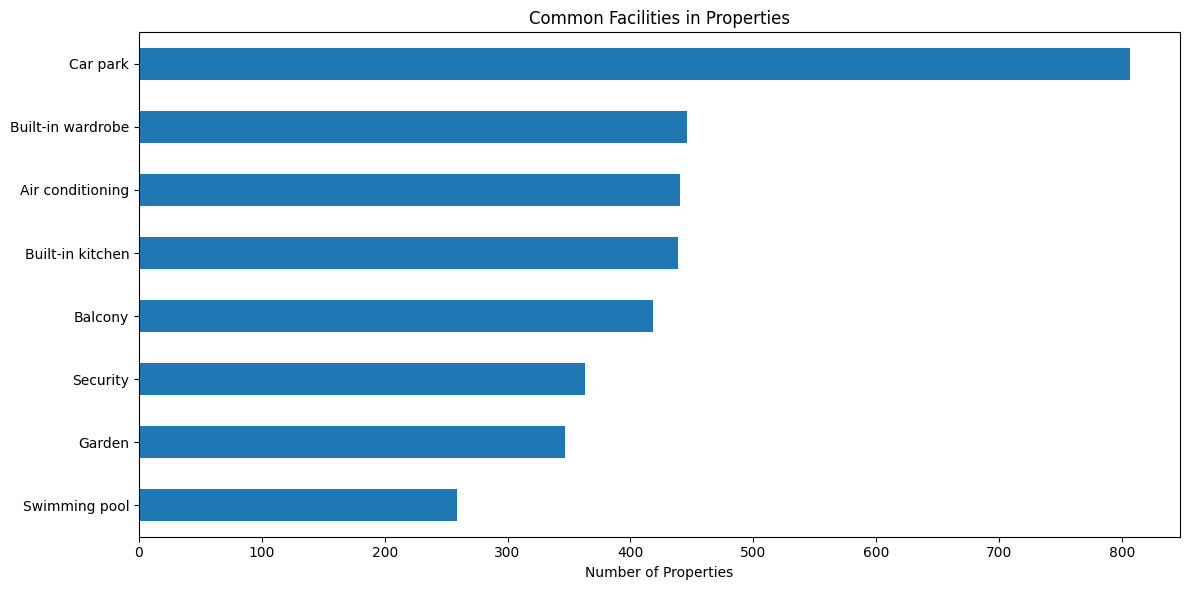


=== Property Dataset Summary ===
Total number of valid properties: 1223

Price Statistics (in millions ₱):
count      0.001223
mean      81.701304
std       84.420657
min        0.075000
25%       29.000000
50%       55.000000
75%      101.828000
max      940.000000
Name: price, dtype: float64

Property Size Statistics:

Floor Area (m²):
count    998.000000
mean     440.100040
std      209.988572
min        3.000000
25%      290.000000
50%      417.500000
75%      553.000000
max      962.000000
Name: floor_area, dtype: float64

Land Area (m²):
count    1071.000000
mean      364.177544
std       190.528462
min         2.000000
25%       240.000000
50%       342.000000
75%       450.000000
max       998.000000
Name: land_area, dtype: float64

Room Statistics:

Number of Bedrooms:
count    1223.000000
mean        4.270646
std         2.414057
min         0.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        50.000000
Name: bedrooms, dtype: float64

Number of 

In [44]:
def clean_price(price):
    """Clean price values by removing currency symbols and commas"""
    try:
        if isinstance(price, str):
            # Remove currency symbol, commas and whitespace
            cleaned = price.replace('₱', '').replace(',', '').strip()
            return float(cleaned)
        return float(price) if pd.notnull(price) else np.nan
    except (ValueError, TypeError):
        return np.nan

def clean_area(area):
    """Clean area values by removing unit indicators"""
    try:
        if isinstance(area, str):
            # Remove 'm2' and whitespace
            cleaned = area.replace(' m2', '').strip()
            return float(cleaned)
        return float(area) if pd.notnull(area) else np.nan
    except (ValueError, TypeError):
        return np.nan

def analyze_property_data(df):
    """
    Analyze and visualize property dataset
    
    Parameters:
    df (pandas.DataFrame): Input property dataset
    """
    # Clean the data first
    df_clean = df.copy()
    
    # Clean numeric columns
    df_clean['price'] = df_clean['price'].apply(clean_price)
    df_clean['floor_area'] = df_clean['floor_area'].apply(clean_area)
    df_clean['land_area'] = df_clean['land_area'].apply(clean_area)
    
    # Convert bedrooms and bathrooms to numeric
    df_clean['bedrooms'] = pd.to_numeric(df_clean['bedrooms'], errors='coerce')
    df_clean['bathrooms'] = pd.to_numeric(df_clean['bathrooms'], errors='coerce')
    
    # Remove rows where price is NaN (we need this for meaningful analysis)
    df_clean = df_clean.dropna(subset=['price'])
    
    print("\nInitial data processing summary:")
    print(f"Original number of properties: {len(df)}")
    print(f"Properties after cleaning: {len(df_clean)}")
    print(f"Rows removed: {len(df) - len(df_clean)}")
    
    # Create figure for price distribution
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(data=df_clean, x='price', bins=20)
    plt.title('Price Distribution')
    plt.xlabel('Price (₱)')
    plt.ticklabel_format(style='plain', axis='x')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df_clean, y='price')
    plt.title('Price Boxplot')
    plt.ylabel('Price (₱)')
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()

    # Create correlation plot for numeric columns
    numeric_cols = ['price', 'bedrooms', 'bathrooms', 'floor_area', 'land_area']
    correlation_data = df_clean[numeric_cols].copy()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_data.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()


    # Facility analysis
    facility_cols = ['Air conditioning', 'Car park', 'Swimming pool', 'Garden', 
                    'Security', 'Balcony', 'Built-in kitchen', 'Built-in wardrobe']
    
    # Ensure all facility columns exist in the dataframe
    facility_cols = [col for col in facility_cols if col in df_clean.columns]
    
    if facility_cols:  # Only create facility plot if we have facility columns
        facility_counts = df_clean[facility_cols].sum().sort_values(ascending=True)
        
        plt.figure(figsize=(12, 6))
        facility_counts.plot(kind='barh')
        plt.title('Common Facilities in Properties')
        plt.xlabel('Number of Properties')
        plt.tight_layout()
        plt.show()

    # Print summary statistics
    print("\n=== Property Dataset Summary ===")
    print(f"Total number of valid properties: {len(df_clean)}")
    print("\nPrice Statistics (in millions ₱):")
    price_stats = df_clean['price'].describe() / 1_000_000
    print(price_stats)
    
    print("\nProperty Size Statistics:")
    print("\nFloor Area (m²):")
    print(df_clean['floor_area'].describe())
    print("\nLand Area (m²):")
    print(df_clean['land_area'].describe())
    
    print("\nRoom Statistics:")
    print("\nNumber of Bedrooms:")
    print(df_clean['bedrooms'].describe())
    print("\nNumber of Bathrooms:")
    print(df_clean['bathrooms'].describe())

    # Print missing value summary
    print("\nMissing Values Summary:")
    missing_summary = df_clean[numeric_cols].isnull().sum()
    print(missing_summary)

analyze_property_data(house)


Initial data processing summary:
Original number of properties: 1226
Properties after cleaning: 1212
Rows removed: 14


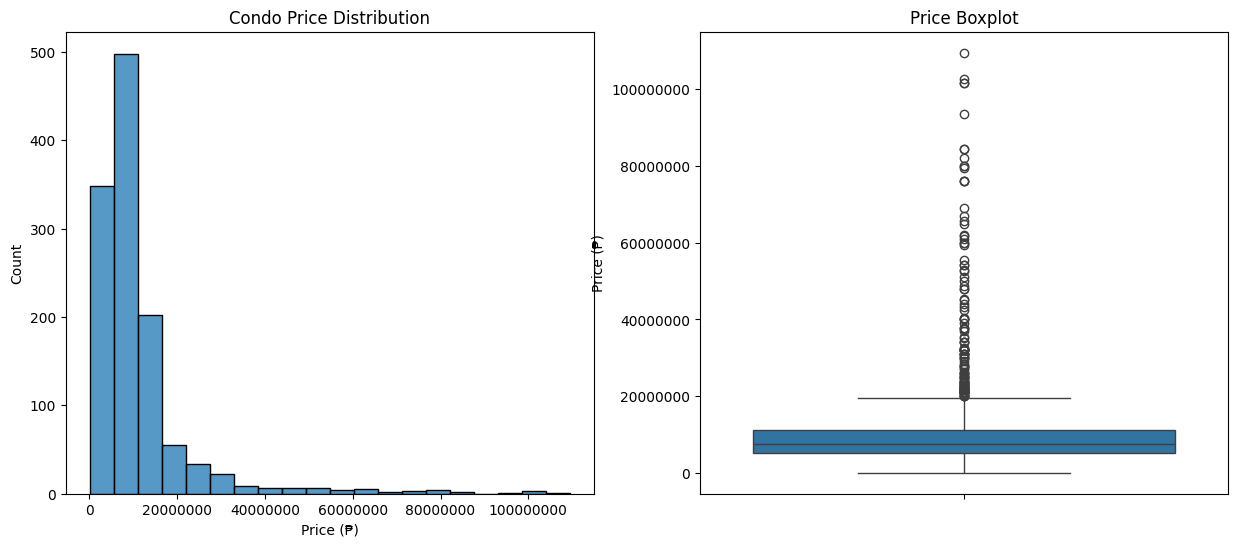

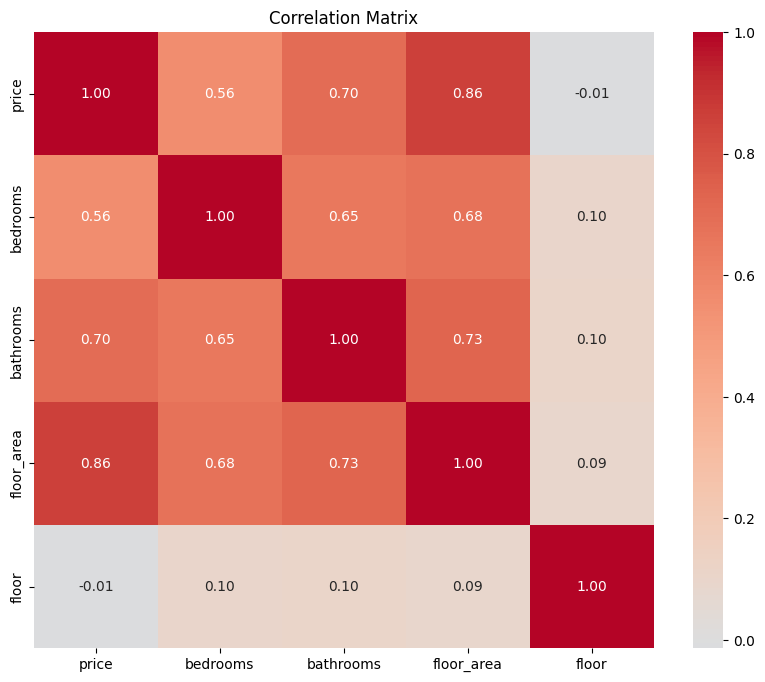

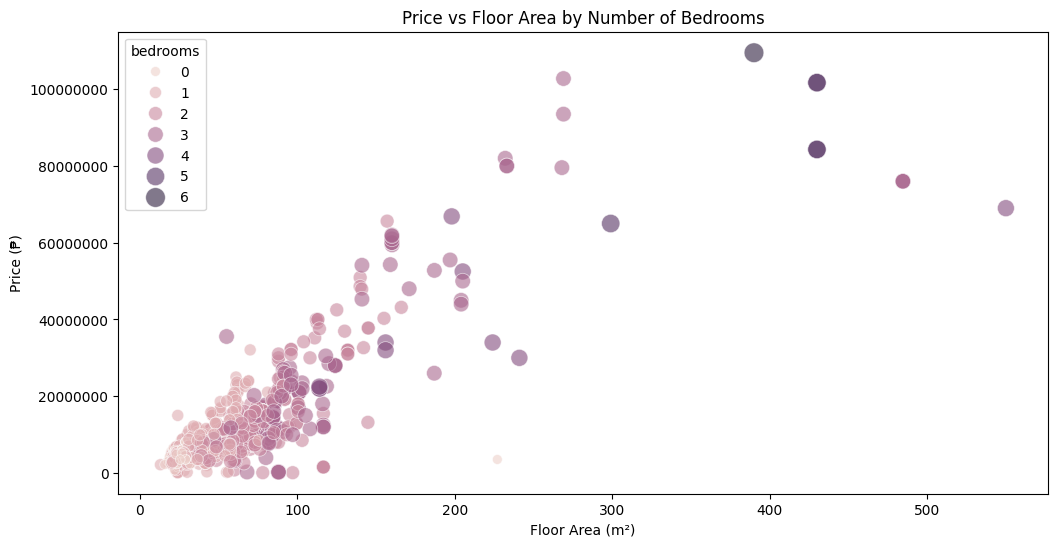

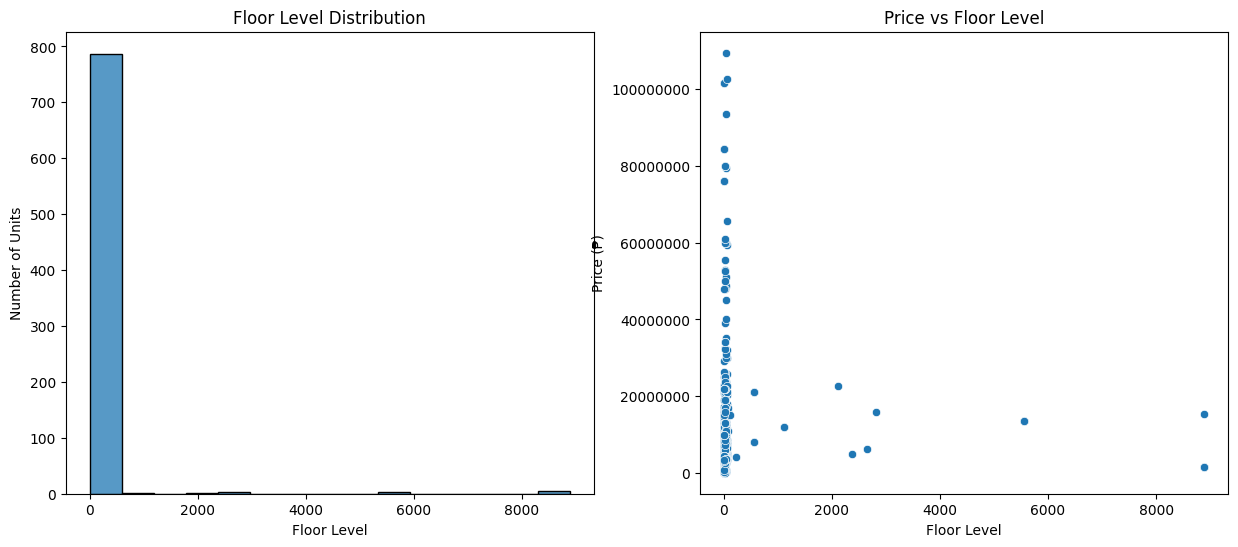

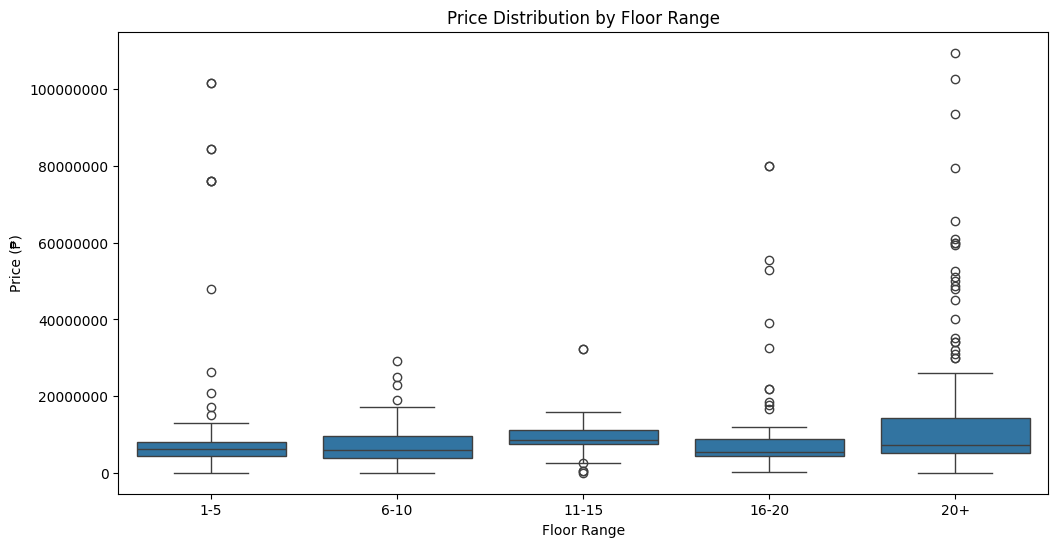

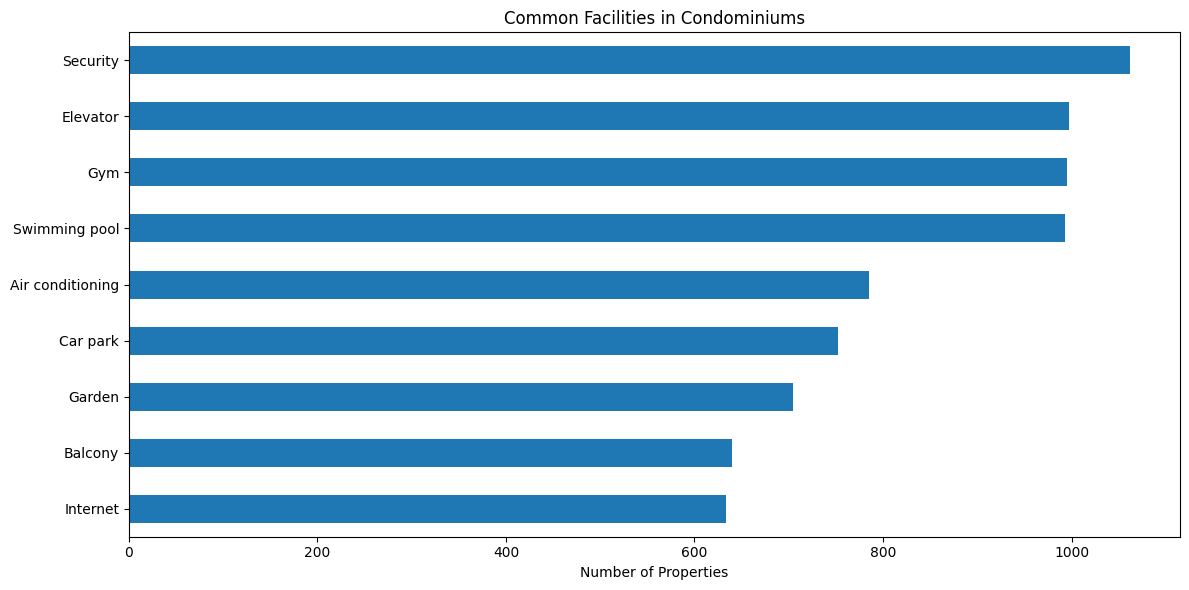


=== Condominium Dataset Summary ===

Price Statistics (in millions ₱):
count      0.001212
mean      11.067714
std       12.395980
min        0.070000
25%        5.254500
50%        7.683701
75%       11.074086
max      109.500000
Name: price, dtype: float64

Size Statistics:

Floor Area (m²):
count    1199.000000
mean       55.978741
std        49.314964
min        13.000000
25%        30.000000
50%        43.190000
75%        61.730000
max       550.000000
Name: floor_area, dtype: float64

Bedroom Distribution:
bedrooms
0.0    231
1.0    559
2.0    296
3.0    110
4.0     10
5.0      5
6.0      1
Name: count, dtype: int64

Average Price by Number of Bedrooms (in millions ₱):
bedrooms
0.0      6.733446
1.0      7.453738
2.0     12.903621
3.0     26.737959
4.0     38.485611
5.0     87.400000
6.0    109.500000
Name: price, dtype: float64

=== Floor Level Analysis ===

Floor Level Statistics:
count     800.000000
mean      102.642500
std       733.264182
min         0.000000
25%        1

/var/folders/8n/jrsz__p10dz9_525b42ylv1c0000gn/T/ipykernel_77452/3708283852.py:163: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_by_floor = df_clean.groupby('floor_range')['price'].mean() / 1_000_000
/var/folders/8n/jrsz__p10dz9_525b42ylv1c0000gn/T/ipykernel_77452/3708283852.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_sqm_by_floor = df_clean.groupby('floor_range')['price_per_sqm'].mean().round(2)


In [43]:
def clean_price(price):
    """Clean price values by removing currency symbols and commas"""
    try:
        if isinstance(price, str):
            # Remove currency symbol, commas and whitespace
            cleaned = price.replace('₱', '').replace(',', '').strip()
            return float(cleaned)
        return float(price) if pd.notnull(price) else np.nan
    except (ValueError, TypeError):
        return np.nan

def clean_area(area):
    """Clean area values by removing unit indicators"""
    try:
        if isinstance(area, str):
            # Remove 'm2' and whitespace
            cleaned = area.replace(' m2', '').strip()
            return float(cleaned)
        return float(area) if pd.notnull(area) else np.nan
    except (ValueError, TypeError):
        return np.nan

def analyze_condo_data(df):
    """
    Analyze and visualize condominium dataset with floor level analysis
    
    Parameters:
    df (pandas.DataFrame): Input condominium dataset
    """
    # Clean the data first
    df_clean = df.copy()
    
    # Clean numeric columns
    df_clean['price'] = df_clean['price'].apply(clean_price)
    df_clean['floor_area'] = df_clean['floor_area'].apply(clean_area)
    df_clean['floor'] = pd.to_numeric(df_clean['floor'], errors='coerce')
    
    # Convert bedrooms and bathrooms to numeric
    df_clean['bedrooms'] = pd.to_numeric(df_clean['bedrooms'], errors='coerce')
    df_clean['bathrooms'] = pd.to_numeric(df_clean['bathrooms'], errors='coerce')
    
    # Remove rows where price is NaN (we need this for meaningful analysis)
    df_clean = df_clean.dropna(subset=['price'])
    
    print("\nInitial data processing summary:")
    print(f"Original number of properties: {len(df)}")
    print(f"Properties after cleaning: {len(df_clean)}")
    print(f"Rows removed: {len(df) - len(df_clean)}")
    
    # Create figure for price distribution
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(data=df_clean, x='price', bins=20)
    plt.title('Condo Price Distribution')
    plt.xlabel('Price (₱)')
    plt.ticklabel_format(style='plain', axis='x')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df_clean, y='price')
    plt.title('Price Boxplot')
    plt.ylabel('Price (₱)')
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()

    # Create correlation plot for numeric columns
    numeric_cols = ['price', 'bedrooms', 'bathrooms', 'floor_area', 'floor']
    correlation_data = df_clean[numeric_cols].copy()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_data.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()

    # Floor area vs Price scatter plot with bedroom colors
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df_clean, x='floor_area', y='price', hue='bedrooms', size='bedrooms',
                    sizes=(50, 200), alpha=0.6)
    plt.title('Price vs Floor Area by Number of Bedrooms')
    plt.xlabel('Floor Area (m²)')
    plt.ylabel('Price (₱)')
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()

    # Floor level analysis visualizations
    plt.figure(figsize=(15, 6))
    
    # Floor level distribution
    plt.subplot(1, 2, 1)
    sns.histplot(data=df_clean, x='floor', bins=15)
    plt.title('Floor Level Distribution')
    plt.xlabel('Floor Level')
    plt.ylabel('Number of Units')
    
    # Price vs Floor Level
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=df_clean, x='floor', y='price')
    plt.title('Price vs Floor Level')
    plt.xlabel('Floor Level')
    plt.ylabel('Price (₱)')
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()

    # Price distribution by floor ranges
    df_clean['floor_range'] = pd.cut(df_clean['floor'], 
                                   bins=[0, 5, 10, 15, 20, float('inf')],
                                   labels=['1-5', '6-10', '11-15', '16-20', '20+'])
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_clean, x='floor_range', y='price')
    plt.title('Price Distribution by Floor Range')
    plt.xlabel('Floor Range')
    plt.ylabel('Price (₱)')
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()

    # Facility analysis
    facility_cols = ['Swimming pool', 'Air conditioning', 'Gym', 'Internet', 
                    'Security', 'Car park', 'Garden', 'Balcony', 'Elevator']
    
    # Ensure all facility columns exist in the dataframe
    facility_cols = [col for col in facility_cols if col in df_clean.columns]
    
    if facility_cols:  # Only create facility plot if we have facility columns
        facility_counts = df_clean[facility_cols].sum().sort_values(ascending=True)
        
        plt.figure(figsize=(12, 6))
        facility_counts.plot(kind='barh')
        plt.title('Common Facilities in Condominiums')
        plt.xlabel('Number of Properties')
        plt.tight_layout()
        plt.show()

    # Print summary statistics
    print("\n=== Condominium Dataset Summary ===")
    print(f"\nPrice Statistics (in millions ₱):")
    price_stats = df_clean['price'].describe() / 1_000_000
    print(price_stats)
    
    print("\nSize Statistics:")
    print("\nFloor Area (m²):")
    print(df_clean['floor_area'].describe())
    
    print("\nBedroom Distribution:")
    print(df_clean['bedrooms'].value_counts().sort_index())
    
    print("\nAverage Price by Number of Bedrooms (in millions ₱):")
    avg_price_by_bedrooms = df_clean.groupby('bedrooms')['price'].mean() / 1_000_000
    print(avg_price_by_bedrooms)

    # Floor level statistics
    print("\n=== Floor Level Analysis ===")
    print("\nFloor Level Statistics:")
    floor_stats = df_clean['floor'].describe()
    print(floor_stats)
    
    print("\nAverage Price by Floor Range (in millions ₱):")
    avg_price_by_floor = df_clean.groupby('floor_range')['price'].mean() / 1_000_000
    print(avg_price_by_floor)
    
    print("\nUnit Distribution by Floor Range:")
    floor_range_dist = df_clean['floor_range'].value_counts().sort_index()
    print(floor_range_dist)
    
    print("\nCorrelation between Floor Level and Price:", 
          df_clean['floor'].corr(df_clean['price']).round(3))

    # Price per square meter analysis
    df_clean['price_per_sqm'] = df_clean['price'] / df_clean['floor_area']
    print("\nPrice per Square Meter (₱):")
    print(df_clean['price_per_sqm'].describe())
    
    print("\nAverage Price per Square Meter by Floor Range (₱):")
    avg_price_sqm_by_floor = df_clean.groupby('floor_range')['price_per_sqm'].mean().round(2)
    print(avg_price_sqm_by_floor)
    
    # Missing value summary
    print("\nMissing Values Summary:")
    missing_summary = df_clean[numeric_cols].isnull().sum()
    print(missing_summary)

analyze_condo_data(condo)


=== Commercial Property Analysis ===

Initial data processing summary:
Original number of properties: 1246
Properties after cleaning: 1217
Rows removed: 29


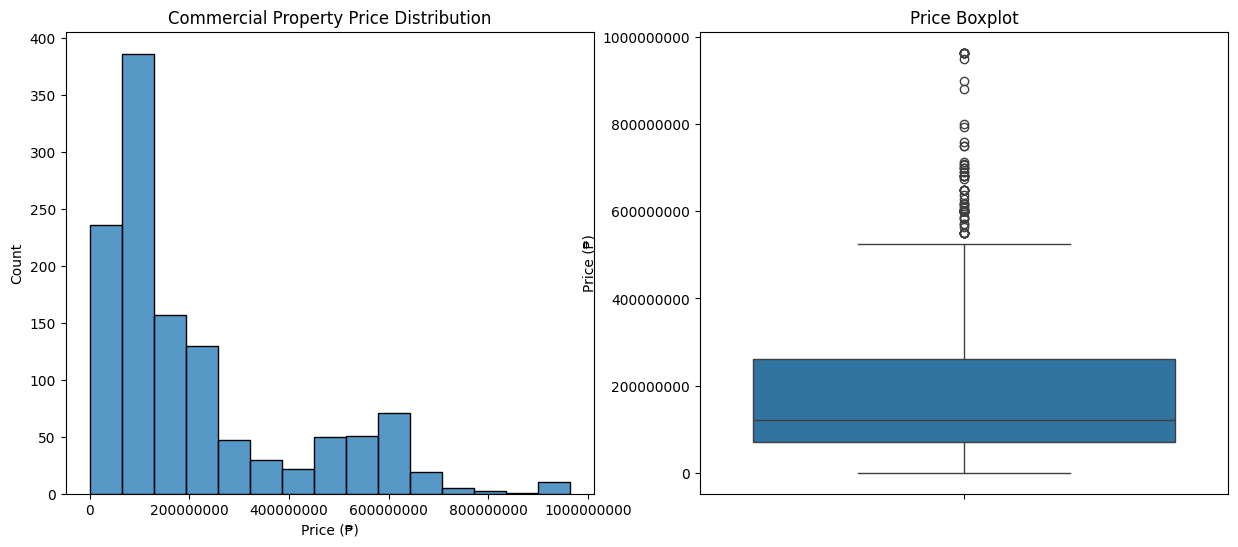

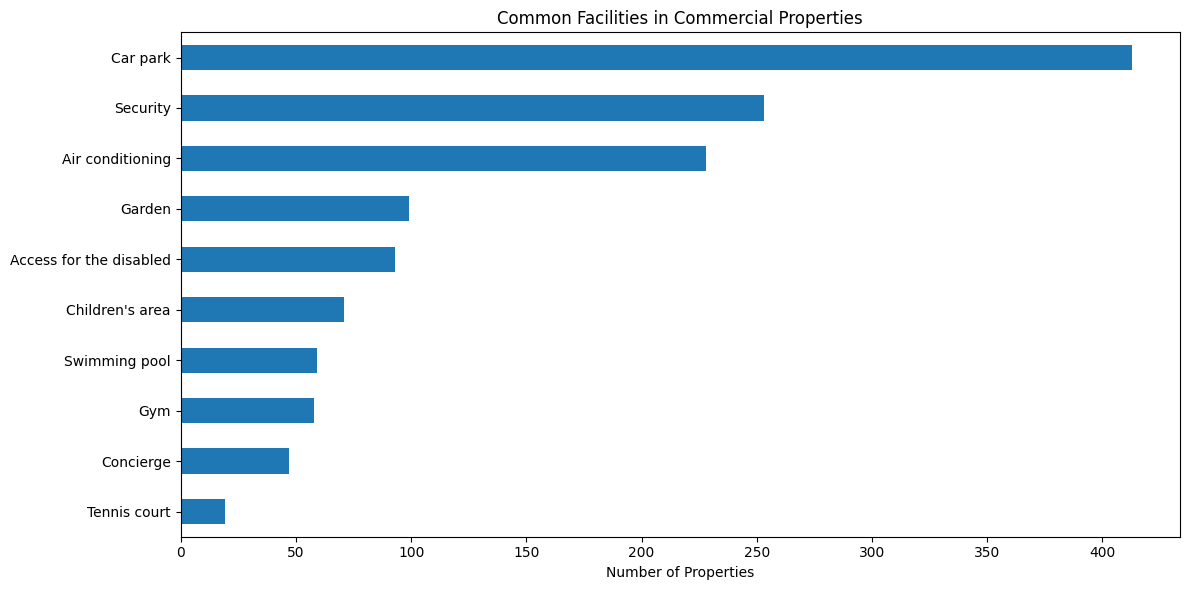


=== Property Statistics ===

Price Statistics (in millions ₱):
count      0.001217
mean     205.829213
std      199.870956
min        0.067000
25%       70.000000
50%      120.000000
75%      260.000000
max      963.900000
Name: price, dtype: float64

Floor Area Statistics (m²):
count      756.000000
mean      1841.216601
std       2143.128644
min          5.000000
25%        410.000000
50%       1045.000000
75%       2140.000000
max      15000.000000
Name: floor_area, dtype: float64

Land Area Statistics (m²):
count     1025.000000
mean       974.958849
std       1308.887615
min         35.000000
25%        339.000000
50%        740.000000
75%       1211.000000
max      22036.000000
Name: land_area, dtype: float64

Price per Square Meter Statistics (₱/m²):
count    7.560000e+02
mean     1.767427e+05
std      5.056336e+05
min      5.000000e+00
25%      8.333333e+04
50%      1.092896e+05
75%      1.875000e+05
max      1.360000e+07
Name: calculated_price_per_sqm, dtype: float64

Propert

In [38]:
def clean_price(price):
    """Clean price values by removing currency symbols and commas"""
    try:
        if isinstance(price, str):
            # Remove currency symbol, commas and whitespace
            cleaned = price.replace('₱', '').replace(',', '').strip()
            return float(cleaned)
        return float(price) if pd.notnull(price) else np.nan
    except (ValueError, TypeError):
        return np.nan

def clean_area(area):
    """Clean area values by removing unit indicators"""
    try:
        if isinstance(area, str):
            # Remove 'm2' and whitespace
            cleaned = area.replace(' m2', '').replace(',', '').strip()
            return float(cleaned)
        return float(area) if pd.notnull(area) else np.nan
    except (ValueError, TypeError):
        return np.nan

def analyze_commercial_data(df):
    """
    Analyze and visualize commercial property dataset
    """
    # Clean the data first
    df_clean = df.copy()
    
    # Clean numeric columns
    df_clean['price'] = df_clean['price'].apply(clean_price)
    df_clean['floor_area'] = df_clean['floor_area'].apply(clean_area)
    df_clean['land_area'] = df_clean['land_area'].apply(clean_area)
    
    # Convert bedrooms to numeric
    df_clean['bedrooms'] = pd.to_numeric(df_clean['bedrooms'], errors='coerce')
    
    # Remove rows where price is NaN
    df_clean = df_clean.dropna(subset=['price'])
    
    print("\n=== Commercial Property Analysis ===")
    print(f"\nInitial data processing summary:")
    print(f"Original number of properties: {len(df)}")
    print(f"Properties after cleaning: {len(df_clean)}")
    print(f"Rows removed: {len(df) - len(df_clean)}")
    
    # Price Distribution Analysis
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(data=df_clean, x='price', bins=15)
    plt.title('Commercial Property Price Distribution')
    plt.xlabel('Price (₱)')
    plt.ticklabel_format(style='plain', axis='x')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df_clean, y='price')
    plt.title('Price Boxplot')
    plt.ylabel('Price (₱)')
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()


    # Facility analysis
    facility_cols = ['Air conditioning', 'Car park', 'Security', 'Garden', 
                    'Access for the disabled', 'Swimming pool', 'Gym', 
                    'Concierge', 'Tennis court', "Children's area"]
    
    # Ensure all facility columns exist in the dataframe
    facility_cols = [col for col in facility_cols if col in df_clean.columns]
    
    if facility_cols:
        facility_counts = df_clean[facility_cols].sum().sort_values(ascending=True)
        
        plt.figure(figsize=(12, 6))
        facility_counts.plot(kind='barh')
        plt.title('Common Facilities in Commercial Properties')
        plt.xlabel('Number of Properties')
        plt.tight_layout()
        plt.show()

    # Calculate price per square meter
    df_clean['calculated_price_per_sqm'] = df_clean['price'] / df_clean['floor_area']
    
    # Print statistics
    print("\n=== Property Statistics ===")
    print("\nPrice Statistics (in millions ₱):")
    price_stats = df_clean['price'].describe() / 1_000_000
    print(price_stats)
    
    print("\nFloor Area Statistics (m²):")
    print(df_clean['floor_area'].describe())
    
    print("\nLand Area Statistics (m²):")
    print(df_clean['land_area'].describe())
    
    print("\nPrice per Square Meter Statistics (₱/m²):")
    price_per_sqm_stats = df_clean['calculated_price_per_sqm'].describe()
    print(price_per_sqm_stats)
    
    # Property type analysis based on bedrooms
    print("\nProperty Distribution by Number of Bedrooms:")
    bedroom_counts = df_clean['bedrooms'].value_counts().sort_index()
    print(bedroom_counts)
    
    # Location analysis
    if 'location' in df_clean.columns:
        print("\nProperty Count by Location:")
        location_counts = df_clean['location'].value_counts()
        print(location_counts)
    
    # Missing values analysis
    print("\nMissing Values Summary:")
    missing_data = df_clean[['price', 'floor_area', 'land_area', 'bedrooms']].isnull().sum()
    print(missing_data)

# Run the analysis
analyze_commercial_data(comm)


=== Apartment Analysis ===

Initial data processing summary:
Original number of properties: 248
Properties after cleaning: 248
Rows removed: 0


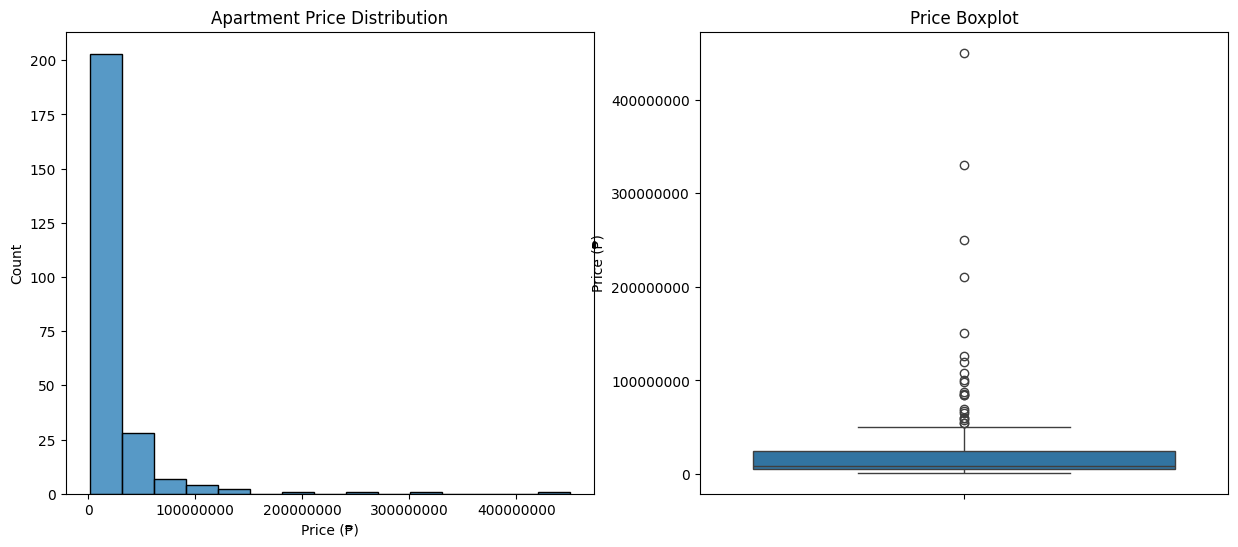

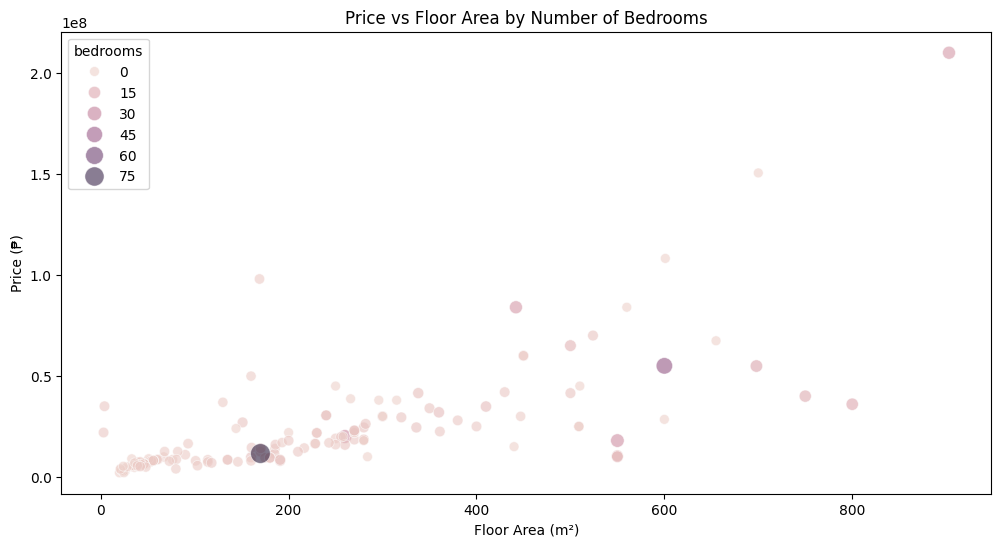

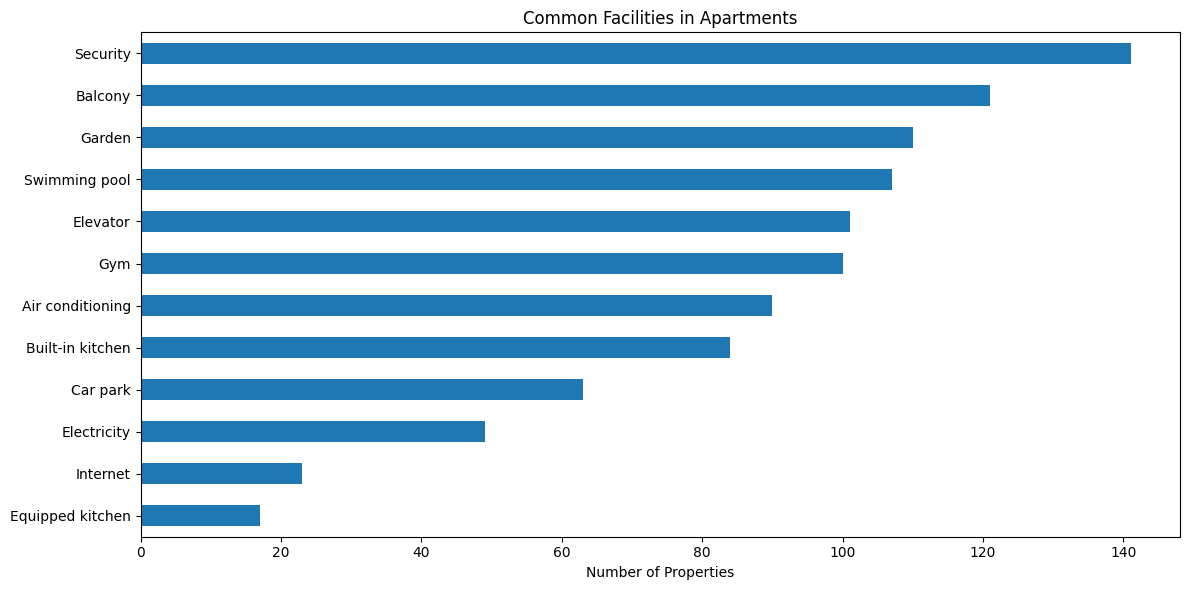


=== Property Statistics ===

Price Statistics (in millions ₱):
count      0.000248
mean      23.670238
std       44.785339
min        1.450551
25%        5.307416
50%        8.998500
75%       24.625000
max      450.000000
Name: price, dtype: float64

Size Statistics:

Floor Area (m²):
count    202.000000
mean     172.498911
std      184.203199
min        3.000000
25%       36.000000
50%       78.250000
75%      260.000000
max      903.000000
Name: floor_area, dtype: float64

Room Statistics:

Number of Bedrooms:
count    248.000000
mean       3.653226
std        7.988904
min        0.000000
25%        0.000000
50%        2.000000
75%        4.000000
max       80.000000
Name: bedrooms, dtype: float64

Number of Bathrooms:
count    199.000000
mean       3.487437
std        5.847264
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       56.000000
Name: bathrooms, dtype: float64

Price per Square Meter (₱/m²):
count    2.020000e+02
mean     1.987847e+05

In [40]:
def clean_price(price):
    """Clean price values by removing currency symbols and commas"""
    try:
        if isinstance(price, str):
            # Remove currency symbol, commas and whitespace
            cleaned = price.replace('₱', '').replace(',', '').strip()
            return float(cleaned)
        return float(price) if pd.notnull(price) else np.nan
    except (ValueError, TypeError):
        return np.nan

def clean_area(area):
    """Clean area values by removing unit indicators"""
    try:
        if isinstance(area, str):
            # Remove 'm2' and whitespace
            cleaned = area.replace(' m2', '').strip()
            return float(cleaned)
        return float(area) if pd.notnull(area) else np.nan
    except (ValueError, TypeError):
        return np.nan

def analyze_apartment_data(df):
    """
    Analyze and visualize apartment dataset
    """
    # Clean the data first
    df_clean = df.copy()
    
    # Clean numeric columns
    df_clean['price'] = df_clean['price'].apply(clean_price)
    df_clean['floor_area'] = df_clean['floor_area'].apply(clean_area)
    
    # Convert numeric columns
    df_clean['bedrooms'] = pd.to_numeric(df_clean['bedrooms'], errors='coerce')
    df_clean['bathrooms'] = pd.to_numeric(df_clean['bathrooms'], errors='coerce')
    df_clean['floor'] = pd.to_numeric(df_clean['floor'], errors='coerce')
    
    # Remove rows where price is NaN
    df_clean = df_clean.dropna(subset=['price'])
    
    print("\n=== Apartment Analysis ===")
    print(f"\nInitial data processing summary:")
    print(f"Original number of properties: {len(df)}")
    print(f"Properties after cleaning: {len(df_clean)}")
    print(f"Rows removed: {len(df) - len(df_clean)}")
    
    # Price Distribution Analysis
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(data=df_clean, x='price', bins=15)
    plt.title('Apartment Price Distribution')
    plt.xlabel('Price (₱)')
    plt.ticklabel_format(style='plain', axis='x')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df_clean, y='price')
    plt.title('Price Boxplot')
    plt.ylabel('Price (₱)')
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()

    # Area vs Price Analysis
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df_clean, x='floor_area', y='price', hue='bedrooms', 
                    size='bedrooms', sizes=(50, 200), alpha=0.6)
    plt.title('Price vs Floor Area by Number of Bedrooms')
    plt.xlabel('Floor Area (m²)')
    plt.ylabel('Price (₱)')
    plt.show()

    # Facility analysis
    facility_cols = ['Internet', 'Car park', 'Balcony', 'Electricity', 'Air conditioning',
                    'Security', 'Built-in kitchen', 'Equipped kitchen', 'Swimming pool',
                    'Gym', 'Elevator', 'Garden']
    
    # Ensure all facility columns exist in the dataframe
    facility_cols = [col for col in facility_cols if col in df_clean.columns]
    
    if facility_cols:
        facility_counts = df_clean[facility_cols].sum().sort_values(ascending=True)
        
        plt.figure(figsize=(12, 6))
        facility_counts.plot(kind='barh')
        plt.title('Common Facilities in Apartments')
        plt.xlabel('Number of Properties')
        plt.tight_layout()
        plt.show()

    # Print statistics
    print("\n=== Property Statistics ===")
    print("\nPrice Statistics (in millions ₱):")
    price_stats = df_clean['price'].describe() / 1_000_000
    print(price_stats)
    
    print("\nSize Statistics:")
    print("\nFloor Area (m²):")
    print(df_clean['floor_area'].describe())
    
    print("\nRoom Statistics:")
    print("\nNumber of Bedrooms:")
    print(df_clean['bedrooms'].describe())
    print("\nNumber of Bathrooms:")
    print(df_clean['bathrooms'].describe())
    
    # Calculate price per square meter
    df_clean['price_per_sqm'] = df_clean['price'] / df_clean['floor_area']
    print("\nPrice per Square Meter (₱/m²):")
    print(df_clean['price_per_sqm'].describe())
    
    # Floor level analysis
    if 'floor' in df_clean.columns:
        print("\nFloor Level Statistics:")
        print(df_clean['floor'].describe())
    
    # Bedroom distribution
    print("\nApartment Distribution by Number of Bedrooms:")
    bedroom_counts = df_clean['bedrooms'].value_counts().sort_index()
    print(bedroom_counts)
    
    # Missing values analysis
    print("\nMissing Values Summary:")
    missing_cols = ['price', 'floor_area', 'bedrooms', 'bathrooms', 'floor']
    missing_data = df_clean[missing_cols].isnull().sum()
    print(missing_data)

# Run the analysis
analyze_apartment_data(apt)

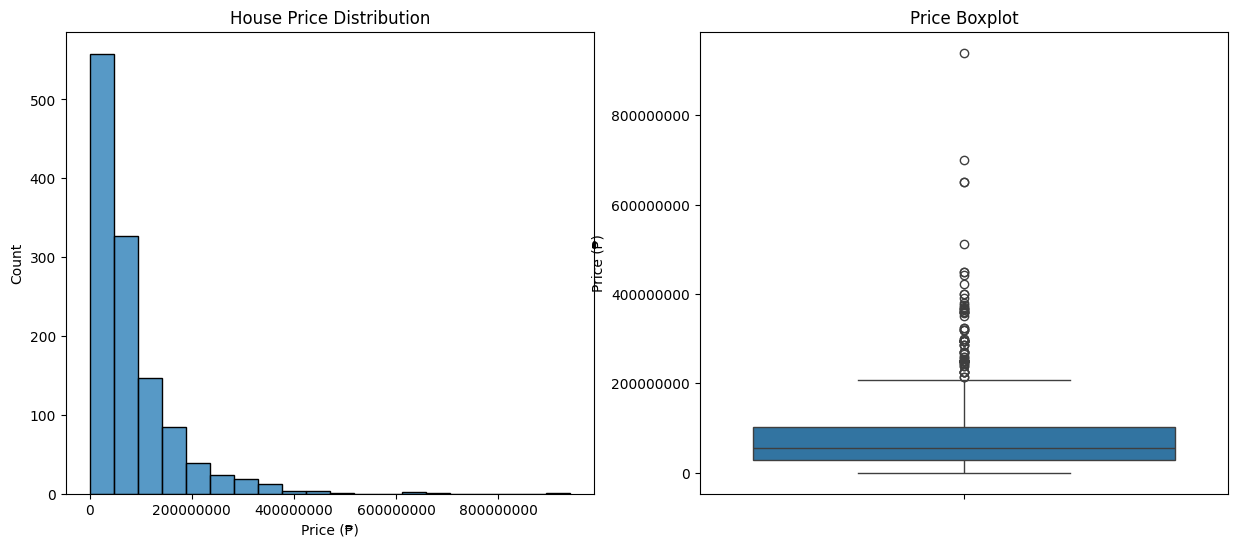

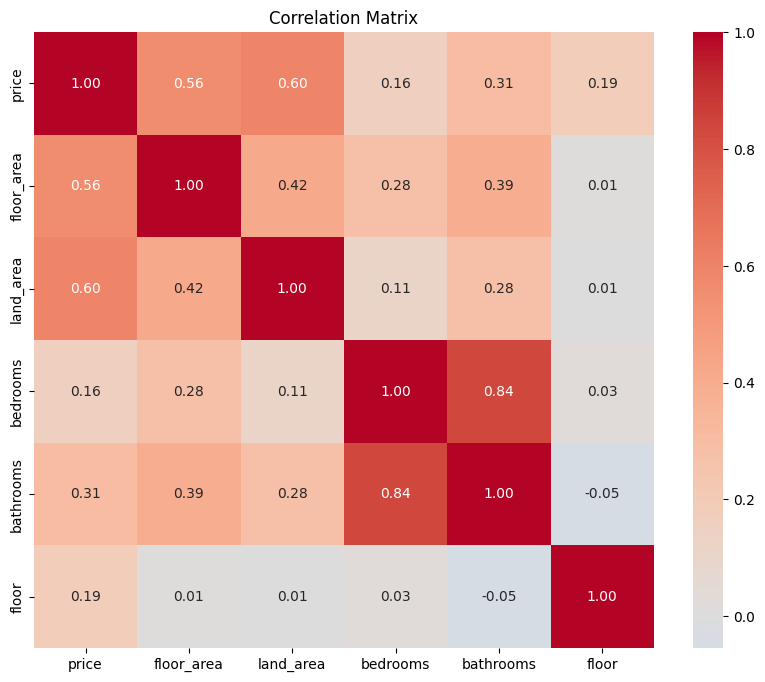

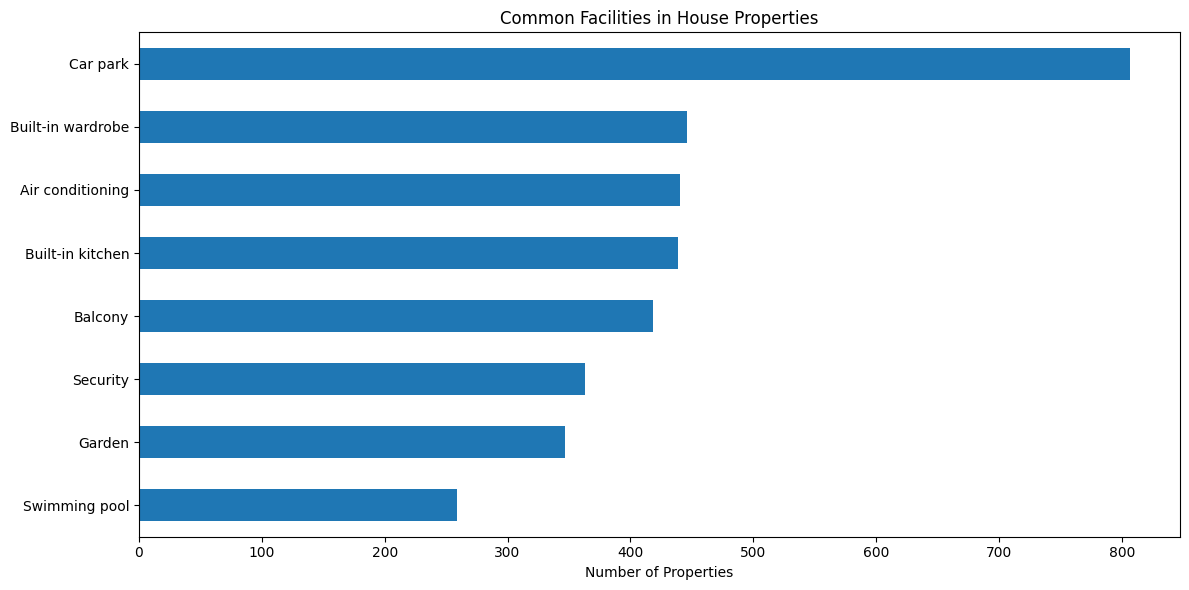

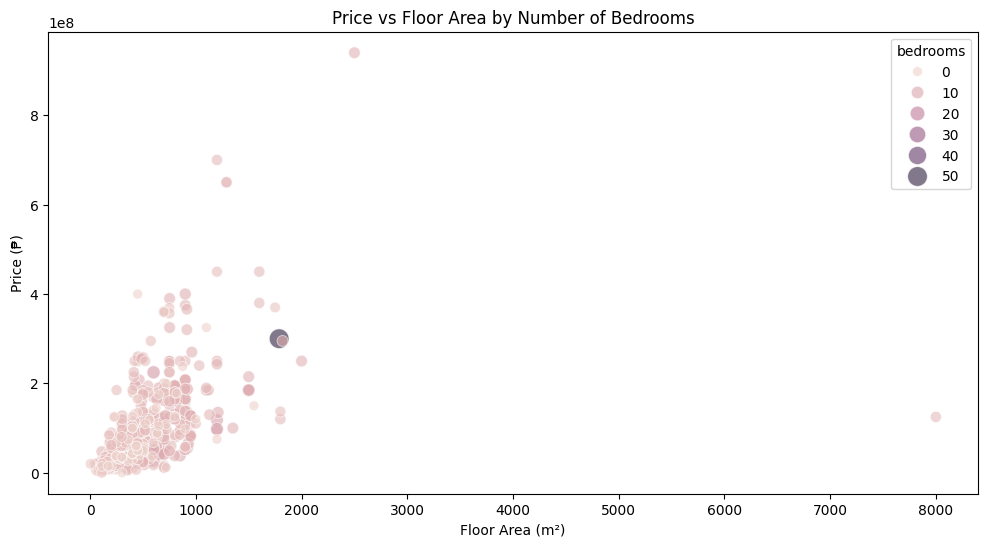


=== House Property Analysis ===
Original number of properties: 1230
Properties after cleaning: 1223
Rows removed: 7

Price Statistics (in millions ₱):
count      0.001223
mean      81.701304
std       84.420657
min        0.075000
25%       29.000000
50%       55.000000
75%      101.828000
max      940.000000
Name: price, dtype: float64

Floor Area Statistics (m²):
count    1038.000000
mean      485.403266
std       371.914795
min         3.000000
25%       300.000000
50%       421.000000
75%       600.000000
max      8000.000000
Name: floor_area, dtype: float64

Land Area Statistics (m²):
count    1124.000000
mean      417.939333
std       352.778767
min         2.000000
25%       240.000000
50%       364.000000
75%       483.000000
max      5516.000000
Name: land_area, dtype: float64

Bedroom Distribution:
bedrooms
0.0     125
1.0       3
2.0      19
3.0     180
4.0     344
5.0     325
6.0      95
7.0      78
8.0      31
9.0       7
10.0      6
11.0      5
12.0      3
13.0      1
50

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def clean_price(price):
    """Clean price values by removing currency symbols and commas"""
    try:
        if isinstance(price, str):
            # Remove currency symbol, commas and whitespace
            cleaned = price.replace('₱', '').replace(',', '').strip()
            return float(cleaned)
        return float(price) if pd.notnull(price) else np.nan
    except (ValueError, TypeError):
        return np.nan

def clean_area(area):
    """Clean area values by removing unit indicators and commas"""
    try:
        if isinstance(area, str):
            # Remove 'm2' and whitespace and commas
            cleaned = area.replace(' m2', '').replace(',', '').strip()
            return float(cleaned)
        return float(area) if pd.notnull(area) else np.nan
    except (ValueError, TypeError):
        return np.nan

class PropertyAnalyzer:
    def __init__(self, df, property_type):
        """
        Initialize PropertyAnalyzer with a dataframe and property type
        
        Parameters:
        df (pandas.DataFrame): Input property dataset
        property_type (str): Type of property ('house', 'condo', 'commercial', 'apartment')
        """
        self.df_original = df
        self.property_type = property_type
        self.df_clean = None
        self.clean_data()

    def clean_data(self):
        """Clean and prepare the data for analysis"""
        self.df_clean = self.df_original.copy()
        
        # Clean numeric columns
        self.df_clean['price'] = self.df_clean['price'].apply(clean_price)
        self.df_clean['floor_area'] = self.df_clean['floor_area'].apply(clean_area)
        
        # Clean property-specific columns
        if self.property_type in ['house', 'commercial']:
            if 'land_area' in self.df_clean.columns:
                self.df_clean['land_area'] = self.df_clean['land_area'].apply(clean_area)
        
        if self.property_type in ['house', 'condo', 'apartment']:
            self.df_clean['bedrooms'] = pd.to_numeric(self.df_clean['bedrooms'], errors='coerce')
            self.df_clean['bathrooms'] = pd.to_numeric(self.df_clean['bathrooms'], errors='coerce')
        
        if self.property_type in ['condo', 'apartment']:
            self.df_clean['floor'] = pd.to_numeric(self.df_clean['floor'], errors='coerce')
        
        # Remove rows where price is NaN
        self.df_clean = self.df_clean.dropna(subset=['price'])

    def plot_price_distribution(self):
        """Plot price distribution histogram and boxplot"""
        plt.figure(figsize=(15, 6))
        
        plt.subplot(1, 2, 1)
        sns.histplot(data=self.df_clean, x='price', bins=20)
        plt.title(f'{self.property_type.title()} Price Distribution')
        plt.xlabel('Price (₱)')
        plt.ticklabel_format(style='plain', axis='x')
        
        plt.subplot(1, 2, 2)
        sns.boxplot(data=self.df_clean, y='price')
        plt.title('Price Boxplot')
        plt.ylabel('Price (₱)')
        plt.ticklabel_format(style='plain', axis='y')
        plt.show()

    def plot_correlation_matrix(self):
        """Plot correlation matrix for numeric columns"""
        numeric_cols = ['price', 'floor_area']
        
        if 'land_area' in self.df_clean.columns:
            numeric_cols.append('land_area')
        if 'bedrooms' in self.df_clean.columns:
            numeric_cols.append('bedrooms')
        if 'bathrooms' in self.df_clean.columns:
            numeric_cols.append('bathrooms')
        if 'floor' in self.df_clean.columns:
            numeric_cols.append('floor')
            
        # Convert to float and handle NA values
        correlation_data = self.df_clean[numeric_cols].apply(pd.to_numeric, errors='coerce')
        
        # Drop any columns that are all NA
        correlation_data = correlation_data.dropna(axis=1, how='all')
        
        # Only create correlation matrix if we have at least 2 columns
        if len(correlation_data.columns) >= 2:
            plt.figure(figsize=(10, 8))
            sns.heatmap(correlation_data.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
            plt.title('Correlation Matrix')
            plt.show()
        else:
            print("Not enough numeric columns with valid data for correlation analysis")
            
    def plot_facility_analysis(self, facility_cols=None):
        """Plot facility analysis"""
        if facility_cols is None:
            facility_cols = {
                'house': ['Air conditioning', 'Car park', 'Swimming pool', 'Garden', 
                         'Security', 'Balcony', 'Built-in kitchen', 'Built-in wardrobe'],
                'condo': ['Swimming pool', 'Air conditioning', 'Gym', 'Internet', 
                         'Security', 'Car park', 'Garden', 'Balcony', 'Elevator'],
                'commercial': ['Air conditioning', 'Car park', 'Security', 'Garden', 
                             'Access for the disabled', 'Swimming pool', 'Gym'],
                'apartment': ['Internet', 'Car park', 'Balcony', 'Electricity', 
                            'Air conditioning', 'Security', 'Built-in kitchen']
            }[self.property_type]
        
        # Ensure all facility columns exist in the dataframe
        facility_cols = [col for col in facility_cols if col in self.df_clean.columns]
        
        if facility_cols:
            facility_counts = self.df_clean[facility_cols].sum().sort_values(ascending=True)
            
            plt.figure(figsize=(12, 6))
            facility_counts.plot(kind='barh')
            plt.title(f'Common Facilities in {self.property_type.title()} Properties')
            plt.xlabel('Number of Properties')
            plt.tight_layout()
            plt.show()

    def plot_area_price_relationship(self):
        """Plot relationship between area and price"""
        if 'bedrooms' in self.df_clean.columns:
            plt.figure(figsize=(12, 6))
            sns.scatterplot(data=self.df_clean, x='floor_area', y='price', 
                          hue='bedrooms', size='bedrooms', sizes=(50, 200), alpha=0.6)
            plt.title('Price vs Floor Area by Number of Bedrooms')
            plt.xlabel('Floor Area (m²)')
            plt.ylabel('Price (₱)')
            plt.show()

    def analyze_floor_levels(self):
        """Analyze floor levels for condos and apartments"""
        if 'floor' in self.df_clean.columns:
            self.df_clean['floor_range'] = pd.cut(
                self.df_clean['floor'],
                bins=[0, 5, 10, 15, 20, float('inf')],
                labels=['1-5', '6-10', '11-15', '16-20', '20+']
            )
            
            plt.figure(figsize=(12, 6))
            sns.boxplot(data=self.df_clean, x='floor_range', y='price')
            plt.title('Price Distribution by Floor Range')
            plt.xlabel('Floor Range')
            plt.ylabel('Price (₱)')
            plt.ticklabel_format(style='plain', axis='y')
            plt.show()

    def print_summary_statistics(self):
        """Print summary statistics"""
        print(f"\n=== {self.property_type.title()} Property Analysis ===")
        print(f"Original number of properties: {len(self.df_original)}")
        print(f"Properties after cleaning: {len(self.df_clean)}")
        print(f"Rows removed: {len(self.df_original) - len(self.df_clean)}")
        
        print("\nPrice Statistics (in millions ₱):")
        price_stats = self.df_clean['price'].describe() / 1_000_000
        print(price_stats)
        
        print("\nFloor Area Statistics (m²):")
        print(self.df_clean['floor_area'].describe())
        
        if 'land_area' in self.df_clean.columns:
            print("\nLand Area Statistics (m²):")
            print(self.df_clean['land_area'].describe())
        
        if 'bedrooms' in self.df_clean.columns:
            print("\nBedroom Distribution:")
            print(self.df_clean['bedrooms'].value_counts().sort_index())
        
        if 'bathrooms' in self.df_clean.columns:
            print("\nBathroom Distribution:")
            print(self.df_clean['bathrooms'].value_counts().sort_index())
        
        if 'floor' in self.df_clean.columns:
            print("\nFloor Level Statistics:")
            print(self.df_clean['floor'].describe())

        # Calculate and print price per square meter
        self.df_clean['price_per_sqm'] = self.df_clean['price'] / self.df_clean['floor_area']
        print("\nPrice per Square Meter (₱/m²):")
        print(self.df_clean['price_per_sqm'].describe())

def analyze_property_dataset(df, property_type):
    """
    Main function to analyze property dataset
    
    Parameters:
    df (pandas.DataFrame): Input property dataset
    property_type (str): Type of property ('house', 'condo', 'commercial', 'apartment')
    """
    analyzer = PropertyAnalyzer(df, property_type)
    
    # Run all analyses
    analyzer.plot_price_distribution()
    analyzer.plot_correlation_matrix()
    analyzer.plot_facility_analysis()
    analyzer.plot_area_price_relationship()
    
    if property_type in ['condo', 'apartment']:
        analyzer.analyze_floor_levels()
    
    analyzer.print_summary_statistics()
    
    return analyzer.df_clean

# Example usage:
analyzed_data = analyze_property_dataset(house, 'house')
# analyzed_data = analyze_property_dataset(condo, 'condo')
# analyzed_data = analyze_property_dataset(commercial, 'commercial')
# analyzed_data = analyze_property_dataset(apartment, 'apartment')